In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tcr
import seaborn as sns

from plotly.subplots import make_subplots
from plotly import graph_objects as go

#allows funnel visuals to show up in HTML
from plotly import offline
offline.init_notebook_mode(connected=True)

#make matplotlib plots included inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#set a default seaborn style
sns.set_style('whitegrid')

import sys
sys.path.append('/home/amybirdee/hobby_projects/functions/stats_tests')
#import custom modules for analysing split tests and formatting tables
from custom_display_df import printResults
from simplify_stats import stat_test

# Data Preview

Preview data to check column types and check for any missing values. 

In [2]:
#read in users table
users = pd.read_csv('/home/amybirdee/hobby_projects/Preply/csv_files/preply_test_users.csv', delimiter = ',')

In [3]:
#check data types - these look fine
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             1918 non-null   int64 
 1   test_group          1918 non-null   object
 2   test_entrance_time  1918 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.1+ KB


In [4]:
#read in transactions table
transactions = pd.read_csv('/home/amybirdee/hobby_projects/Preply/csv_files/preply_test_transactions.csv', delimiter = ',')

In [5]:
#check data types - gmv has object data type due to the dollar sign. Need to change this to integer
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       913 non-null    int64 
 1   gmv           913 non-null    object
 2   payment_time  913 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.5+ KB


In [6]:
#remove dollar sign and convert gmv to integer
transactions['gmv'] = transactions['gmv'].str.replace('$', '')
transactions['gmv'] = transactions['gmv'].astype(int)

In [7]:
#datatypes are now as expected
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       913 non-null    int64 
 1   gmv           913 non-null    int64 
 2   payment_time  913 non-null    object
dtypes: int64(2), object(1)
memory usage: 21.5+ KB


In [8]:
#save this new file as csv. The analysis on both files will be done in SQL 
transactions.to_csv('/home/amybirdee/hobby_projects/Preply/csv_files/preply_test_transactions_final.csv', index = False)

# Functions

Define functions that will be used in the analysis.

In [9]:
#function to determine significance
def key_rev_metric_stats(df, revenue_column, payer_flag_column, arpu_name, pp_name):
    
    df = df.sort_values('Variant', ascending = False)
    
    results = pd.concat(
    
    [stat_test(
        data = df,
        kind = 'mwu_userlevel',
        variant_column = 'Variant',
        p_value_correction = True,
        metric_columns = [revenue_column],
        metric_names = [arpu_name]),
     
     stat_test(
         data = df,
         kind = 'chi2_userlevel',
         variant_column = 'Variant',
         p_value_correction = True,
         metric_columns = [payer_flag_column],
         metric_names = [pp_name])])
    
    return results

In [10]:
#define function for revenue charts
def revenue_charts(df_plt, metric_formats):
    """
    df_plt: summary df of metrics by variant
    metric_formats: dict of {df_metric_name:[friendly_name, 'formatter']}    
    """

    fig, axes = plt.subplots(1,len(metric_formats),figsize = (20,7.5))

    for i,m in enumerate(metric_formats.keys()):
        ax = axes[i]
        m_min = min(df_plt[m])
        m_max = max(df_plt[m])

        ax.bar(df_plt['Variant'], df_plt[m], color = ['#FFB3CF', '#FF7AAC'])
        #ax.set_ylim(0,m_max*1.025)
        ax.set_ylim(m_min * 0, m_max * 1.1)
        ax.set_title(metric_formats[m][0])
        ax.yaxis.set_major_formatter(metric_formats[m][1])

In [11]:
#define function to create a funnel chart
def funnel_chart(title_1, title_2, df):
    fig = make_subplots(rows = 1, cols = 2,
          subplot_titles = (title_1,
                            title_2),
                    shared_yaxes = True,
                    vertical_spacing = 0.15)
    
    fig.add_trace(go.Funnel
              (name = title_1,
              y = ['Test Users', 'Purchased Subscription'],
              x = [df.iloc[0,1], df.iloc[0,2]],
              textinfo = 'percent initial + value',
              texttemplate = '%{value:,d}<br>%{percentInitial}',
              hoverinfo = 'text + percent previous',
              marker = {'color': ['#FF7AAC', '#FF7AAC']}),
              row = 1, col = 1)

    fig.add_trace(go.Funnel
              (name = title_2,
              y = ['Test Users', 'Purchased Subscription'],
              x = [df.iloc[1,1], df.iloc[1,2]],
              textinfo = 'percent initial + value',
              texttemplate = '%{value:,d}<br>%{percentInitial}',
              hoverinfo = 'text + percent previous',
              marker = {'color': ['#FF7AAC', '#FF7AAC']}),
              row = 1, col = 2)


    #set background colour to transparent
    fig.update_layout(height = 300, width = 1000, plot_bgcolor = 'rgba(0,0,0,0)', showlegend = False)
    fig.show()

In [12]:
#define function for side by side bar chart (2 bars)
def side_by_side_bar(i, bar_number, y, colour, y1, colour1, formatter, lim, x, rotation, xlabel, ylabel, 
                     label, label1, title):
    
    plt.rcParams['figure.figsize'] = (20, 6)
    ax = plt.subplot(i)
    
    #determine number of bars
    num_bars = bar_number
    
    #determine how bars will be arranged along x axis
    x_ticks = np.arange(num_bars)
    
    #space between bars
    width = 0.4
    
    bar_1 = ax.bar(x_ticks, y, width, color = colour)
    bar_2 = ax.bar(x_ticks + width, y1, width, color = colour1)
    
    #set y axis format and limit
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylim(lim)
    
    ax.set_xticks(x_ticks + width / 2)
    ax.set_xticklabels(x, rotation = rotation, fontsize = 12)
    ax.set_xlabel(xlabel, fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.legend((bar_1, bar_2), (label, label1), loc = 'best')
    ax.set_title(title, fontsize = 14)
    
    #adjust space between subplots
    plt.subplots_adjust(hspace = 0.4)

# Revenue

In [13]:
#read csv - this is a SQL output
revenue = pd.read_csv('/home/amybirdee/hobby_projects/Preply/csv_files/revenue.csv', delimiter = ',')

In [14]:
#reformat the columns we're interested in - fill in NaN columns and rename them
revenue['revenue'] = revenue['revenue'].fillna(0)
revenue = revenue.rename(columns = {'variant': 'Variant',
                                    'revenue': 'Revenue',
                                    'payer': 'Payer Flag'})

## Total Revenue and Payers

In [15]:
#Calculate total revenue and payers
revenue_total = revenue.groupby('Variant')[['Revenue', 'Payer Flag']].sum().reset_index()

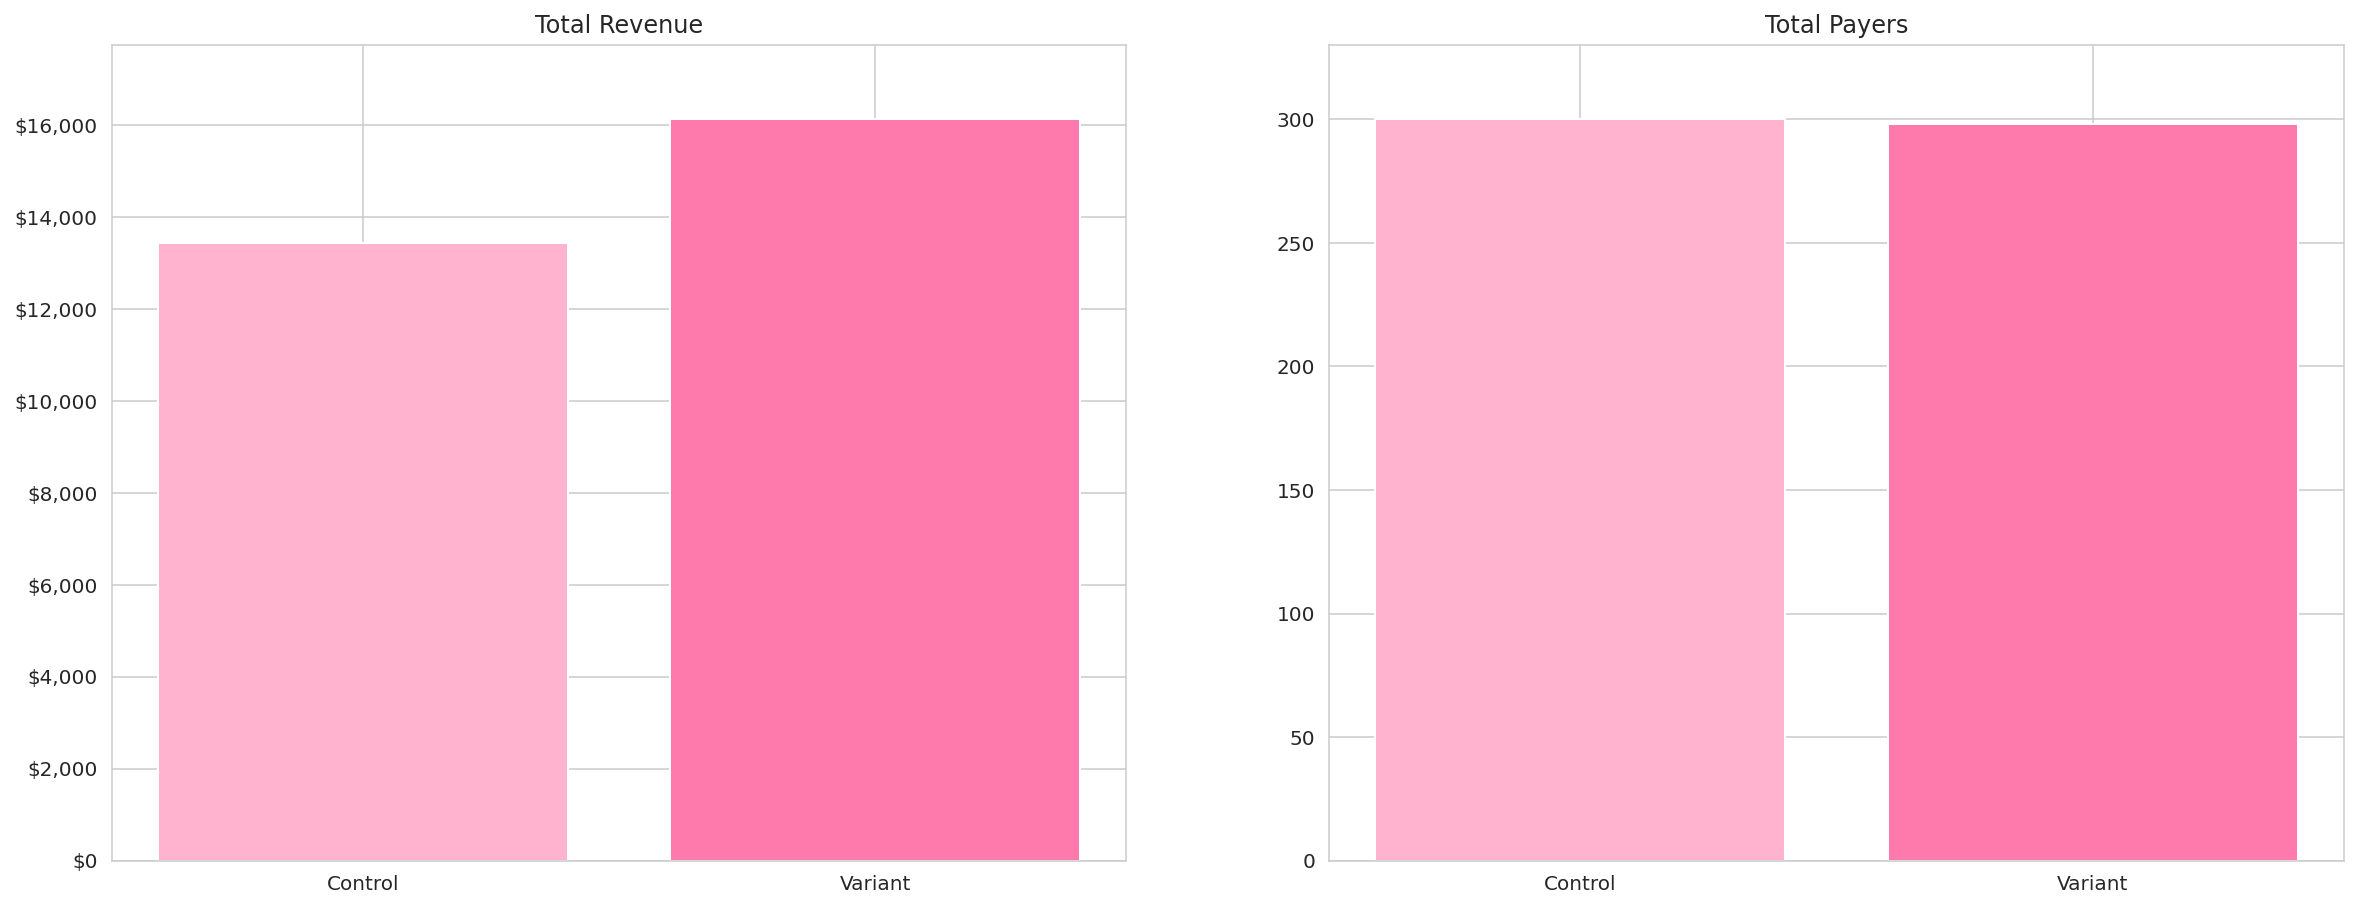

In [16]:
#plot results using avbove funstion    
metric_formats = {'Revenue':['Total Revenue', tcr.StrMethodFormatter('${x:,.0f}')],
                  'Payer Flag':['Total Payers', tcr.StrMethodFormatter('{x:,.0f}')]}
    
revenue_charts(revenue_total, metric_formats)

In [17]:
#pivot total revenue data and calculate uplift
revenue_pivot = revenue_total.pivot_table(columns = 'Variant',
                                          values = 'Revenue').\
reset_index().rename_axis(None, axis = 1).rename(columns = {'index': 'Metric'})

#add uplift column
revenue_pivot['Uplift'] = revenue_pivot['Variant'] - revenue_pivot['Control']

#apply formatting
for column in revenue_pivot:
    if column != 'Metric':
        revenue_pivot[column] = revenue_pivot[column].apply(lambda x: "${:,.0f}".format(x))

printResults(revenue_pivot, show_index = False)

Metric,Control,Variant,Uplift
Revenue,"$13,446","$16,127","$2,681"


## Average Revenue Per User and Payer Penetration

In [18]:
#Calculate average revenue per user (ARPU) and payer penetration (%PP)
revenue_summary = revenue.groupby('Variant')[['Revenue', 'Payer Flag']].mean().reset_index()

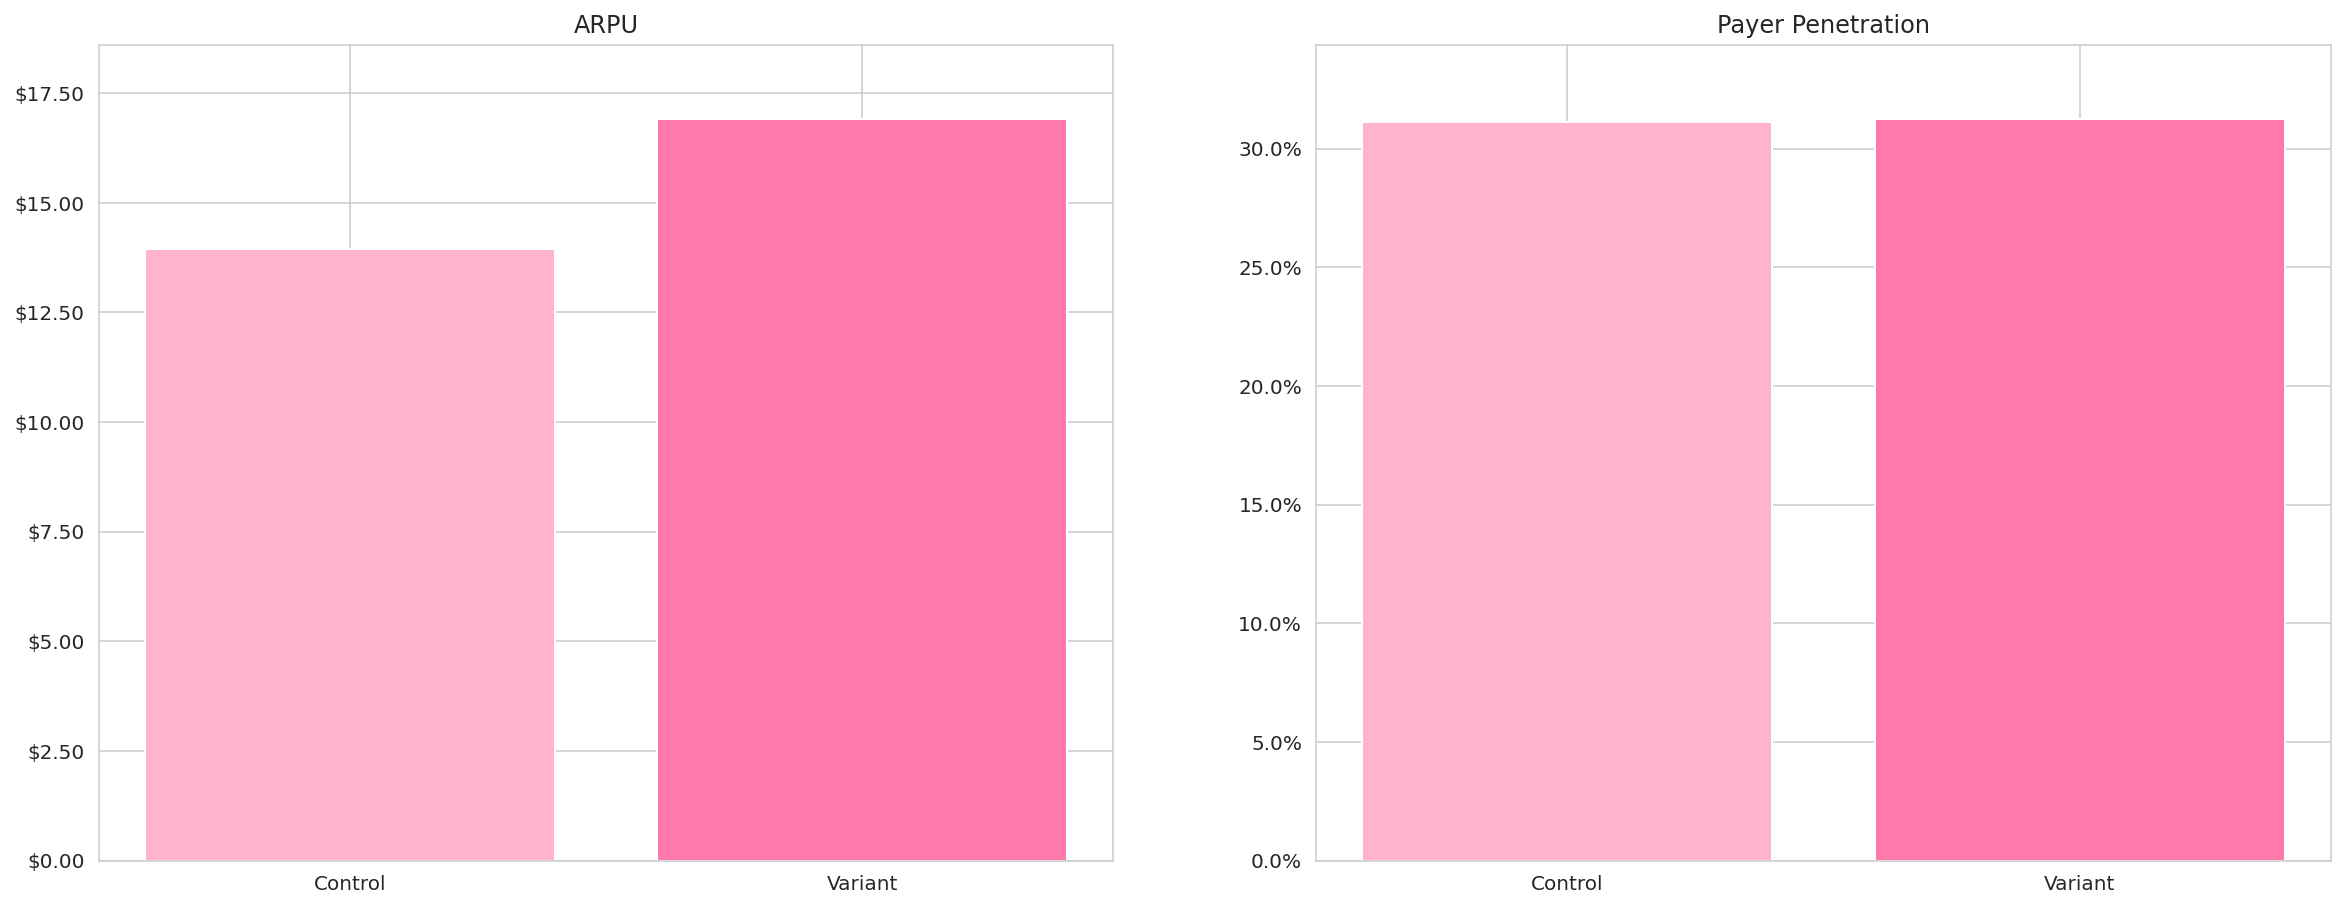

In [19]:
#plot results using avbove funstion    
metric_formats = {'Revenue':['ARPU', tcr.StrMethodFormatter('${x:,.2f}')],
                  'Payer Flag':['Payer Penetration', tcr.PercentFormatter(1,1)]}
    
revenue_charts(revenue_summary, metric_formats)

In [20]:
#create summary table. ARPU was higher for the variant, payer penetration was similar between both groups
revenue_summary.columns = ['Variant', 'ARPU ($)', 'PP (%)']

printResults(revenue_summary, manual_formats = {'ARPU ($)': '${:,.2f}', 
                                         'PP (%)': '{:,.2%}'}, show_index = False)


Variant,ARPU ($),PP (%)
Control,$13.95,31.12%
Variant,$16.90,31.24%


In [21]:
#print results. Calculating significance using above function
results = key_rev_metric_stats(revenue, 'Revenue', 'Payer Flag', 'ARPU', 'PP')

printResults(results[['Metric', 'Highest Performing Cohort', 'P-Value', 'Significance?', 
                                 'Percent Difference']], manual_formats = {'Variant 1 value':'{:,.3f}', 
                                                                           'Variant 2 value':'{:,.3f}'}, \
                                                                            show_index = False)


Metric,Highest Performing Cohort,P-Value,Significance?,Percent Difference
ARPU,Variant,0.2807,✘,21.2%
PP,Variant,0.9561,✘,0.4%


# User Funnel and Conversion

Find conversion rates for both groups.

In [22]:
#read in funnel query
funnel = pd.read_csv('/home/amybirdee/hobby_projects/Preply/csv_files/funnel.csv', delimiter = ',')

In [23]:
#apply function for funnel chart
funnel_chart('Control',
             'Variant',
             funnel)

# Time of Purchase

Find out how long after test entry users purchased a subscription or top-up.

In [24]:
#read in csv
purchase_time = pd.read_csv('/home/amybirdee/hobby_projects/Preply/csv_files/time_of_purchase.csv', delimiter = ',')

In [25]:
#pivot data for chart
purchase_time_pivot = purchase_time.pivot_table(columns = 'variant',
                                                values = ['day_1_purchase',
                                                          'day_2_purchase',
                                                          'day_3_purchase'])\
.reset_index().rename_axis(None, axis = 1).rename(columns = {'index': 'Day'})

#rename rows for chart
purchase_time_pivot['Day'] = purchase_time_pivot['Day'].str.replace('day', 'Day')\
.str.replace('_', ' ').str.replace('purchase', '')

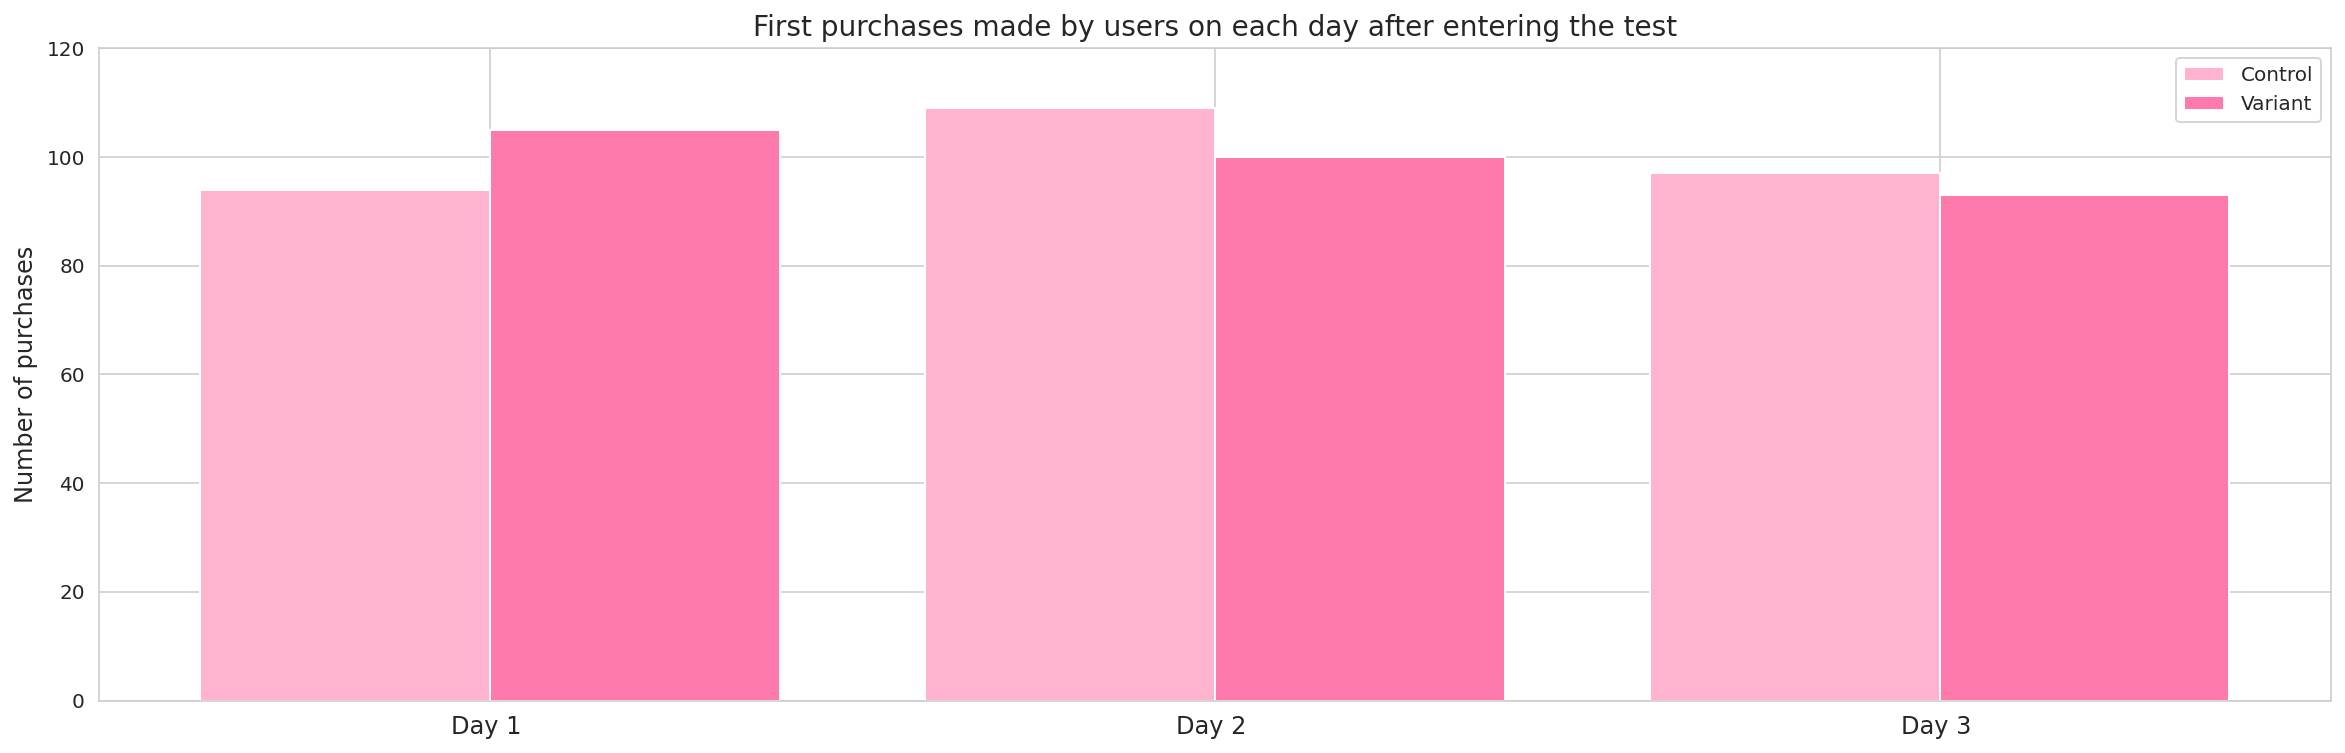

In [26]:
#apply function for chart
side_by_side_bar((111), 3, purchase_time_pivot['Control'], '#FFB3CF', purchase_time_pivot['Variant'],
                '#FF7AAC', tcr.StrMethodFormatter('{x:,.0f}'), (0, 120), purchase_time_pivot['Day'],
                None, None, 'Number of purchases', 'Control', 'Variant',
                'First purchases made by users on each day after entering the test')

In [5]:
#convert to html file
!jupyter nbconvert --to html Preply_speaking_practice_experiment_analysis.ipynb

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
[NbConvertApp] Converting notebook Preply_speaking_practice_experiment_analysis.ipynb to html
[NbConvertApp] Writing 518610 bytes to Preply_speaking_practice_experiment_analysis.html
